In [ ]:
import genophenocorr
import hpotk
from IPython.display import display, HTML
store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

In [2]:
ANKRD11_id = 'NM_013275.6' # MANE select
from genophenocorr.preprocessing import configure_caching_cohort_creator, load_phenopacket_folder

fpath_phenopackets = r'phenopackets'
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
cohort = load_phenopacket_folder(fpath_phenopackets, cohort_creator)


Patients Created: 100%|██████████| 337/337 [00:01<00:00, 320.91it/s]
Validated under none policy
Showing errors and warnings
337 phenopacket(s) found at `phenopackets`
  patient #1
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Behnert, 2018[PMID_36446582_Behnert_2018]. Remove variant from testing
     ·Patient PMID_36446582_Behnert_2018 has no variants to work with
  patient #3
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Bucerzan2020[PMID_36446582_Bucerzan2020]. Remove variant from testing
     ·Patient PMID_36446582_Bucerzan2020 has no variants to work with
  patient #4
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Crippa2015_P1[PMID_36446582_Crippa2015_P1]. Remove variant from testing
     ·Pa

In [3]:
protein_id = 'NP_001027558.1'
from genophenocorr.preprocessing import UniprotProteinMetadataService
pms = UniprotProteinMetadataService()
protein_metas = pms.annotate(protein_id)

from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService

In [4]:
txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(ANKRD11_id)
protein_id = 'NP_037407.4' 
from genophenocorr.preprocessing import UniprotProteinMetadataService
pms = UniprotProteinMetadataService()
protein_metas = pms.annotate(protein_id)

In [5]:
from genophenocorr.view import ProteinVisualizable
protein_meta = protein_metas[0]
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

y_ticks=array([ 7, 14, 21, 28]) y_ticks_relative=array([0.54371291, 0.56942581, 0.59513872, 0.62085162])
y_axis_min_y=0.518 y_axis_max_y=0.6428912529307607


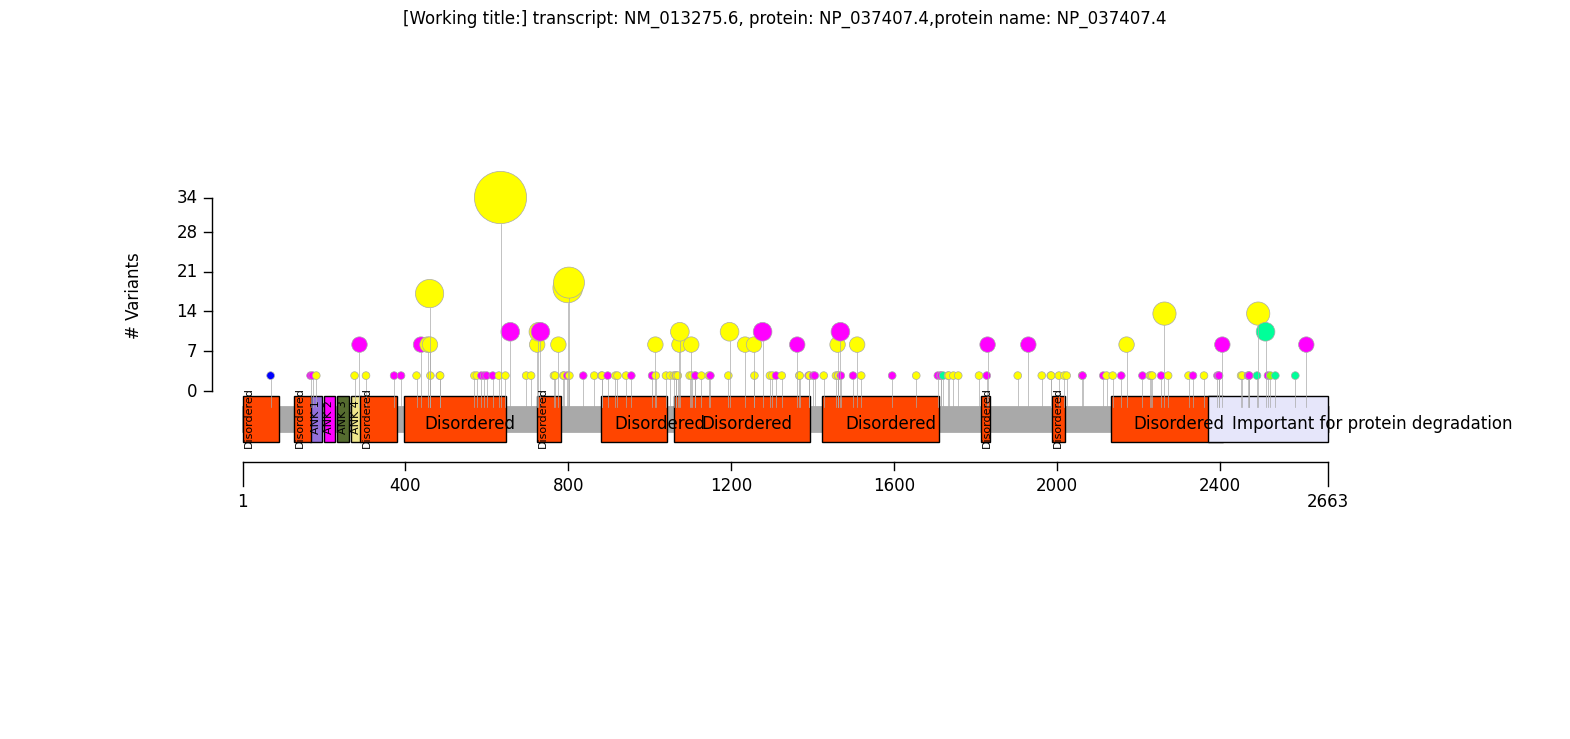

In [6]:
from genophenocorr.view import ProteinVisualizer
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [7]:
import numpy as np
variant_locations_counted_absolute, marker_counts = np.unique(variant_locations, axis=0, return_counts=True)

NameError: name 'variant_locations' is not defined